In [26]:
import pandas as pd
import numpy as np
import warnings
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [ ]:
#!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 2.7 MB/s 


In [22]:
df = pd.read_csv("Train.csv")
df

test = pd.read_csv("Test.csv")
sentences_test = test["ABSTRACT"]

tags = pd.read_csv("Tags.csv")
tgs = tags["Tags"].tolist()

labels = df[tgs]

sentences = df["ABSTRACT"].values
sentences.shape

n = np.argmax(sentences)
maxlen = len(sentences[n])
df.head(3)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [4]:
df.shape

(14004, 31)

In [30]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_val, train_labels, val_labels = train_test_split(sentences, labels, test_size = 0.2, random_state = 1)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)
combined = list(sentences_train) + list(sentences_val)
vectorizer.fit(combined)

sentences_train_feature = vectorizer.transform(sentences_train)
sentences_val_feature = vectorizer.transform(sentences_val)
sentences_test_feature = vectorizer.transform(sentences_test)
sentences_train_feature.shape
sentences_val_feature.shape

(2801, 10000)

## Training models using CountVectorizer

In [31]:
model = LabelPowerset(LogisticRegression())
model.fit(sentences_train_feature, train_labels)
ypred = model.predict(sentences_val_feature)

from sklearn.metrics import accuracy_score
print("Validation accuracy: ", accuracy_score(ypred, val_labels))

Validation accuracy:  0.4805426633345234


In [27]:
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression())
model.fit(sentences_train_feature, train_labels)
ypred = model.predict(sentences_val_feature)

from sklearn.metrics import f1_score, accuracy_score

print("Validation accuracy: ", accuracy_score(val_labels, ypred))

Validation accuracy:  0.38629061049625135


## Training models using TfidfVectorizer

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
_ = vec.fit(list(sentences_train) + list(sentences_val))

trn_abs = vec.transform(sentences_train)
val_abs = vec.transform(sentences_val)

In [29]:
model = LabelPowerset(LogisticRegression())
model.fit(trn_abs, train_labels)
ypred = model.predict(val_abs)

In [10]:
from sklearn.metrics import accuracy_score
print("Validation accuracy: ", accuracy_score(val_labels, ypred))

Validation accuracy:  0.4966083541592288


In [11]:
clf = OneVsRestClassifier(LogisticRegression())
_ = clf.fit(trn_abs, train_labels)

val_preds = clf.predict(val_abs)
print("Validation accuracy: ", accuracy_score(val_labels, val_preds))

Validation accuracy:  0.25098179221706535


## Deep Learning

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

encoder = LabelEncoder()
tags_labels = encoder.fit_transform(tgs)
tags_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_val)

vocab_size = len(tokenizer.word_index) + 1

print(sentences_train[2])
print(X_train[2])

a egalitarian processor sharing model was viewed as the restless bandit and its whittle indexability was established. the numerical scheme considering computing a whittle indices was provided, along with supporting numerical experiments.
[1, 18681, 12160, 2096, 24, 8, 2502, 16, 3, 18682, 2049, 4, 63, 15605, 24082, 8, 1012, 3, 256, 421, 9, 872, 1, 15605, 3325, 8, 597, 515, 10, 3216, 256, 142]


In [14]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

y_train = train_labels
y_test = val_labels

print("Train shape: ", X_train.shape)
print("Train labels shape: ", train_labels.shape)

print("Test shape: ", X_test.shape)
print("Test labels shape: ", val_labels.shape)

Train shape:  (11203, 1193)
Train labels shape:  (11203, 25)
Test shape:  (2801, 1193)
Test labels shape:  (2801, 25)


## Flattening layer model

In [15]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(25, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1193, 50)          1944150   
                                                                 
 flatten (Flatten)           (None, 59650)             0         
                                                                 
 dense (Dense)               (None, 100)               5965100   
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
Total params: 7,911,775
Trainable params: 7,911,775
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/20
1121/1121 [==============================] - 15s 11ms/step - loss: 0.1541 - accuracy: 0.3216 - val_loss: 0.1130 - val_accuracy: 0.4720
Epoch 2/20
1121/1121 [==============================] - 12s 11ms/step - loss: 0.0709 - accuracy: 0.6757 - val_loss: 0.1007 - val_accuracy: 0.5452
Epoch 3/20
1121/1121 [==============================] - 12s 10ms/step - loss: 0.0233 - accuracy: 0.7958 - val_loss: 0.1207 - val_accuracy: 0.5370
Epoch 4/20
1121/1121 [==============================] - 12s 11ms/step - loss: 0.0056 - accuracy: 0.8207 - val_loss: 0.1520 - val_accuracy: 0.5441
Epoch 5/20
1121/1121 [==============================] - 12s 10ms/step - loss: 0.0018 - accuracy: 0.8288 - val_loss: 0.1831 - val_accuracy: 0.5509
Epoch 6/20
1121/1121 [==============================] - 12s 10ms/step - loss: 8.3123e-04 - accuracy: 0.8202 - val_loss: 0.1779 - val_accuracy: 0.5455
Epoch 7/20
1121/1121 [==============================] - 12s 10ms/step - loss: 5.2418e-04 - accuracy: 0.8271 - val_loss: 

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.8086
Testing Accuracy:  0.5237


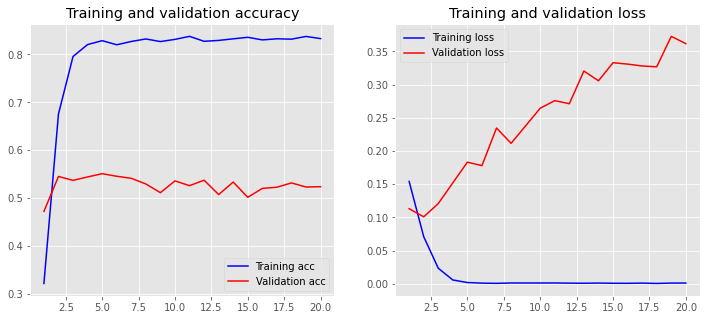

In [18]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Maxpooling layer model

In [19]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(25, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1193, 50)          1944150   
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 25)                2525      
                                                                 
Total params: 1,951,775
Trainable params: 1,951,775
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/20
1121/1121 [==============================] - 11s 10ms/step - loss: 0.2143 - accuracy: 0.1791 - val_loss: 0.1786 - val_accuracy: 0.2003
Epoch 2/20
1121/1121 [==============================] - 10s 9ms/step - loss: 0.1659 - accuracy: 0.2385 - val_loss: 0.1551 - val_accuracy: 0.2649
Epoch 3/20
1121/1121 [==============================] - 10s 9ms/step - loss: 0.1434 - accuracy: 0.3171 - val_loss: 0.1350 - val_accuracy: 0.3602
Epoch 4/20
1121/1121 [==============================] - 10s 9ms/step - loss: 0.1238 - accuracy: 0.4086 - val_loss: 0.1210 - val_accuracy: 0.4138
Epoch 5/20
1121/1121 [==============================] - 10s 9ms/step - loss: 0.1104 - accuracy: 0.4640 - val_loss: 0.1138 - val_accuracy: 0.4370
Epoch 6/20
1121/1121 [==============================] - 10s 9ms/step - loss: 0.1001 - accuracy: 0.5051 - val_loss: 0.1084 - val_accuracy: 0.4645
Epoch 7/20
1121/1121 [==============================] - 10s 9ms/step - loss: 0.0914 - accuracy: 0.5522 - val_loss: 0.1064 - val_a

Training Accuracy: 0.7850
Testing Accuracy:  0.4784


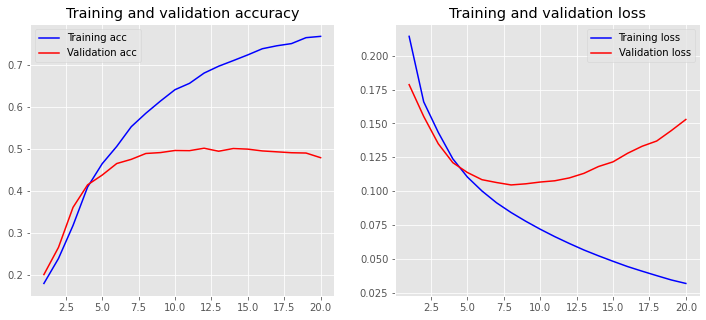

In [21]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)